In [7]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from sklearn.model_selection import train_test_split

In [8]:
X_circles, y_circles = make_circles(n_samples=1000, noise=0.05, factor=0.5, random_state=42)

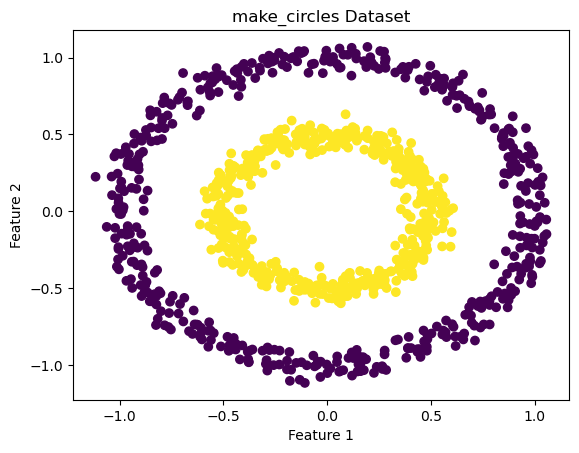

In [9]:
# Plot the generated data
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, cmap='viridis')
plt.title("make_circles Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [10]:
moon_df = pd.DataFrame({"X": X_circles[:,0],"Y":  X_circles[:,1],"label": y_circles })
moon_df

,X,Y,label
0,0.452592,0.168433,1
1,-0.438027,0.119900,1
2,-0.532224,0.184359,1
3,-0.301402,0.400782,1
4,0.445602,-0.894936,0
...,...,...,...
995,0.249091,0.925787,0
996,-0.985370,-0.288162,0
997,-0.072016,-0.531447,1
998,0.660905,-0.793190,0


In [11]:
torch.__version__

'2.6.0+cpu'

In [12]:
X = torch.from_numpy(X_circles).type(torch.float)
y = torch.from_numpy(y_circles).type(torch.float)

In [13]:
# train_test_split of the data
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [14]:
print(f""" 
      input Values: {X_train[:5]}
      output_label: {y_train[:5]}
      
      """)

 
      input Values: tensor([[ 0.4413, -0.2603],
        [ 0.6030, -0.7328],
        [-1.0219, -0.1066],
        [-0.9613, -0.2265],
        [-0.1010,  0.5180]])
      output_label: tensor([1., 0., 0., 0., 1.])
      
      


In [15]:
len(X_train),len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

In [16]:
type(X_train),X_train.dtype, X_train.device, X_train.requires_grad

(torch.Tensor, torch.float32, device(type='cpu'), False)

In [158]:
# building model 
device = "cuda" if torch.cuda.is_available() else "cpu"


class NeuralNetworkClassification(nn.Module):
    """docstring for ."""
    def __init__(self):
        super().__init__()
        # define all the layers of the models
        self.linear1 = nn.Linear(in_features=2, out_features=5)
        self.linear2 = nn.Linear(in_features= 5, out_features= 1)
        self.sigmoid = nn.Sigmoid()
        
        # using sequentail method
        # self.sequential_layer = nn.Sequential(
        #     nn.Linear(in_features=2, out_features=5),
        #     nn.Linear(in_features=5, out_features=1)
        # )
    
    def forward(self,x):
        x = self.linear1(x)
        x= self.linear2(x)
        # we used nn.BCEWithLogitsLoss (which is the combination of Sigmoid and BCELoss) so we don't need to sigmoid here
        output = self.sigmoid(x)
        return output 
        
        # sequentail method 
        # return self.sequential_layer(x)

    

In [159]:
torch.manual_seed(42)
model = NeuralNetworkClassification().to(device)
model

NeuralNetworkClassification(
  (linear1): Linear(in_features=2, out_features=5, bias=True)
  (linear2): Linear(in_features=5, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [160]:
model.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]])),
             ('linear1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410])),
             ('linear2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]])),
             ('linear2.bias', tensor([-0.2060]))])

tensor([[0.4649],
        [0.4606],
        [0.4518]], grad_fn=<SigmoidBackward0>)

In [98]:
# loss and optimizer for the classification problem

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001)



In [ ]:
# # training and testing loop 
# epochs = 10
# for epoch in range(epochs):
#     model.train()
    
#     # forward pass 
#     y_pred = model(X_train)
#     # loss_fn(model(X_train[:3]),torch.unsqueeze(y_train[:3],dim=1))
#     loss = loss_fn(y_pred,y_train)
    
    
#     # backpropagation 
#     loss.backward()
#     optimizer.step()
#     optimizer.zero_grad()
    
    
#     # testing loop 
    
#     model.eval()
#     with torch.inference_mode():
#         y_test_pred = model(X_test)
#         # loss_fn(model(X_train[:3]),torch.unsqueeze(y_train[:3],dim=1))
#         test_loss = loss_fn(y_test_pred,y_test)
        
    
    
    
#     if epoch % 10 == 0:
          
#             print(f"loss: {loss} ")
    
    
    
    

In [168]:
y_test_pred = model(X_test)
y_test_pred[:10]

tensor([[0.4666],
        [0.4760],
        [0.4571],
        [0.4733],
        [0.4592],
        [0.4626],
        [0.4794],
        [0.4765],
        [0.4557],
        [0.4761]], grad_fn=<SliceBackward0>)

In [167]:
y_test_pred = model(X_test)
torch.sigmoid(y_test_pred[:10])

tensor([[0.6146],
        [0.6168],
        [0.6123],
        [0.6162],
        [0.6128],
        [0.6136],
        [0.6176],
        [0.6169],
        [0.6120],
        [0.6168]], grad_fn=<SigmoidBackward0>)